In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt

# Модели YOLO

**YOLO** (You Only Look Once) – семейство одностадийных моделей для детекции объектов в реальном времени, которое кардинально изменило подход к этой задаче в компьютерном зрении. Вместо того чтобы рассматривать детекцию как задачу классификации отдельных участков изображения, **YOLO** подходит к ней как к регрессионной проблеме, предсказывая ограничивающие рамки (bounding boxes) и вероятности классов для всего изображения за один проход нейронной сети.

# [YOLOv1](https://arxiv.org/abs/1506.02640)

### Принцип работы

1. **Разделение изображения на сетку.** Входное изображение делится на сетку размером **SxS** (в оригинальной статье S=7). Если центр **ground-truth** бокса попадает в ячейку **(i, j)**, эта ячейка «отвечает» за детекцию этого объекта. Ячейка может отвечать только за один объект (на практике обучаем так, чтобы в одну ячейку не попадало два центра). $\newline$

2. **Backbone.** Данные пропускаются через данную сеть, получается карта признаков. Например, цветное изображение **3x448x448** подается на вход, на выходе получается карта признаков **1024x7x7**. $\newline$

3. **Переход на регрессию: Flatten + FC.** Выпрямление **(Flatten)** тензора **1024x7x7** → вектор длины **7·7·1024** = **50 176**. Дальше идут полносвязные слои:
    - FC1: 50 176 → 4 096 + LeakyReLU(0.1) + Dropout(0.5).
    - FC2: 4 096 → S·S·(B·5 + C) выходов.
    
    В оригинальной статье B=2 бокса, C=20 классов → 7·7·(2·5 + 20) = 7·7·30 = 1 470 выходов. Данный вектор переводится в тензор размерности **(7, 7, 30)**. По порядку в 30 числах: первые 5 чисел — первый бокс, следующие 5 — второй бокс, затем 20 чисел — вероятности классов. Каждый бокс (5 чисел) выглядит так: **(x, y, w, h, conf)**. **(x, y)** — смещение центра бокса относительно левого верхнего угла (угол задан в индексах ячейки) ячейки. **(w, h) ∈ [0, 1]** — нормированные размеры бокса по отношению к размерам изображения (например, к 448). **conf** - уверенность модели. $\newline$

4. **Функция потерь.** 

    **YOLOv1** оптимизируется взвешенным **MSE**

**$$
\mathcal{L} = \lambda_{\text{coord}} \sum_{i=1}^{S^2} \sum_{j=1}^{B} \mathbf{1}_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] \\
+ \lambda_{\text{coord}} \sum_{i,j} \mathbf{1}_{ij}^{\text{obj}} \left[ (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right] \\
+ \sum_{i,j} \mathbf{1}_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2 + \lambda_{\text{noobj}} \sum_{i,j} \mathbf{1}_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2 \\
+ \sum_{i=1}^{S^2} \mathbf{1}_{i}^{\text{obj}} \sum_{k=1}^{C} (p_i(k) - \hat{p}_i(k))^2
$$**

* **Обозначения:**$\newline$
    * $S^2$: Количество ячеек сетки, на которые разбивается изображение (например, $7 \times 7 = 49$). $\newline$
    * $B$: Количество предсказываемых ограничивающих рамок (bounding boxes) для каждой ячейки сетки (например, 2). Модель выдвигает B разных "гипотез" в виде B ограничивающих рамок. $\newline$
    * $C$: Количество классов объектов. $\newline$
    * $\mathbf{1}_{ij}^{\text{obj}}$: Индикаторная функция, равная 1, если $j$-я ограничивающая рамка в $i$-й ячейке сетки отвечает за обнаружение объекта (т.е. имеет самый высокий IoU с истинной рамкой объекта); в противном случае 0. $\newline$
    * $\mathbf{1}_{ij}^{\text{noobj}}$: Индикаторная функция, равная 1, если $j$-я ограничивающая рамка в $i$-й ячейке сетки **не** содержит объекта; в противном случае 0. $\mathbf{1}_{ij}^{\text{noobj}} = \mathbf{1} - \mathbf{1}_{ij}^{\text{obj}}$ $\newline$
    * $(x_i, y_i)$: Координаты центра истинной ограничивающей рамки относительно ячейки сетки. $\newline$
    * $(\hat{x}_i, \hat{y}_i)$: Предсказанные координаты центра ограничивающей рамки относительно ячейки сетки. $\newline$
    * $w_i, h_i$: Истинные ширина и высота ограничивающей рамки (нормализованные относительно размера изображения). $\newline$
    * $\hat{w}_i, \hat{h}_i$: Предсказанные ширина и высота ограничивающей рамки. $\newline$
    * $C_i$: Истинная оценка достоверности (confidence score) для $i$-й ячейки (1, если ячейка содержит центр объекта, 0 в противном случае). $\newline$
    * $\hat{C}_i$: Предсказанная оценка достоверности для $i$-й ячейки. $\newline$
    * $p_i(k)$: Истинная условная вероятность класса $k$ для $i$-й ячейки, при условии, что в ней есть объект. $\newline$
    * $\hat{p}_i(k)$: Предсказанная условная вероятность класса $k$. $\newline$
    * $\lambda_{\text{coord}}$: Весовой коэффициент для потерь локализации (координат). YOLOv1 придает больший вес потерям локализации, чтобы модель точнее предсказывала позиции и размеры объектов (обычно 5). $\newline$
    * $\lambda_{\text{noobj}}$: Весовой коэффициент для потерь достоверности для ячеек без объектов. YOLOv1 придает меньший вес этим потерям, поскольку большинство ячеек сетки не содержат объектов (обычно 0.5). $\newline$

* **Члены функции потерь:**

    1.  **Потери на координаты центра объекта (x, y):**
        $$ \lambda_{\text{coord}} \sum_{i=1}^{S^2} \sum_{j=1}^{B} \mathbf{1}_{ij}^{\text{obj}} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right] $$
        Этот член штрафует модель за неточное предсказание центра объекта $(x_i, y_i)$. Он активируется только для тех ограничивающих рамок, которые "отвечают" за обнаружение объекта (т.е. $\mathbf{1}_{ij}^{\text{obj}}=1$). 

    2.  **Потери на размеры объекта (ширина w, высота h):**
        $$ \lambda_{\text{coord}} \sum_{i,j} \mathbf{1}_{ij}^{\text{obj}} \left[ (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right] $$
        Этот член штрафует модель за неточное предсказание ширины и высоты объекта. Вместо прямых $w$ и $h$ используются их квадратные корни, чтобы уменьшить чувствительность к ошибкам предсказания больших ограничивающих рамок по сравнению с маленькими. Маленькие ошибки в предсказании больших рамок менее критичны, чем аналогичные ошибки в маленьких рамках. Также активируется только для рамок, отвечающих за объект.

    3.  **Потери на достоверность для ячеек с объектами и без объектов:**
        $$ \sum_{i,j} \mathbf{1}_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2 + \lambda_{\text{noobj}} \sum_{i,j} \mathbf{1}_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2 $$
        Этот член состоит из двух частей:
        * Первая часть: $\sum_{i,j} \mathbf{1}_{ij}^{\text{obj}} (C_i - \hat{C}_i)^2$ штрафует предсказания достоверности ($\hat{C}_i$) для ячеек, которые **содержат** объекты. Истинная достоверность $C_i$ равна 1 в этом случае.
        * Вторая часть: $\lambda_{\text{noobj}} \sum_{i,j} \mathbf{1}_{ij}^{\text{noobj}} (C_i - \hat{C}_i)^2$ штрафует предсказания достоверности ($\hat{C}_i$) для ячеек, которые **не содержат** объектов. Истинная достоверность $C_i$ равна 0 в этом случае. Здесь используется весовой коэффициент $\lambda_{\text{noobj}}$, так как класс "нет объекта" встречается намного чаще.

    4.  **Потери на классификацию (условные вероятности классов):**
        $$ \sum_{i=1}^{S^2} \mathbf{1}_{i}^{\text{obj}} \sum_{k=1}^{C} (p_i(k) - \hat{p}_i(k))^2 $$
        Этот член штрафует модель за неточные предсказания условных вероятностей классов $(\hat{p}_i(k))$. Он вычисляется только для тех ячеек сетки, которые содержат объект ($\mathbf{1}_{ij}^{\text{obj}}=1$), поскольку классовая информация имеет смысл только при наличии объекта.
        
### Инференс и пост-обработка

1.  Отбрасываем боксы с confidence < 0.2. (0.2 - пример, может быть и другой порог) $\newline$

2.  Перевод координат в абсолютные пиксели: 

    $$
    X = (i + x) \frac{448}{7}, \quad W = w \cdot 448
    $$

3.  Non-Maximum Suppression (NMS)
    * Сортировка по class score.
    * Удаление пересекающихся с IoU > 0.5.

# Возможная реализация YOLOv1

In [2]:
import torch
import torch.nn as nn

In [4]:
class YOLOLossFunction(nn.Module):
    def __init__(self, S, B, classes, lambda_coord=5, lambda_noobj=0.5):
        super().__init__()
        self.S = S
        self.B = B
        self.classes = classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction='sum')
    
    def compute_iou(self, box1, box2):
        # box: (N, 4) → x, y, w, h 
        box1_x1 = box1[..., 0] - box1[..., 2] / 2
        box1_y1 = box1[..., 1] - box1[..., 3] / 2
        box1_x2 = box1[..., 0] + box1[..., 2] / 2
        box1_y2 = box1[..., 1] + box1[..., 3] / 2

        box2_x1 = box2[..., 0] - box2[..., 2] / 2
        box2_y1 = box2[..., 1] - box2[..., 3] / 2
        box2_x2 = box2[..., 0] + box2[..., 2] / 2
        box2_y2 = box2[..., 1] + box2[..., 3] / 2

        inter_x1 = torch.max(box1_x1, box2_x1)
        inter_y1 = torch.max(box1_y1, box2_y1)
        inter_x2 = torch.min(box1_x2, box2_x2)
        inter_y2 = torch.min(box1_y2, box2_y2)

        inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)

        box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
        union = box1_area + box2_area - inter_area + 1e-6

        return inter_area / union
    
    def forward(self, X, targets):
        device = X.device
        BATCH_SIZE = X.shape[0]
        S, B, C = self.S, self.B, self.classes
        pred_boxes = X[..., :B*5].view(BATCH_SIZE, S, S, B, 5)  # [Batch, S, S, B, 5]
        pred_cls = X[..., B*5:]                                 # [Batch, S, S, C]
        
        obj_mask = torch.zeros((BATCH_SIZE, S, S, B), device=device)   # [Batch, S, S, B]
        noobj_mask = torch.ones((BATCH_SIZE, S, S, B), device=device)  # [Batch, S, S, B]
        
        gt_boxes = torch.zeros_like(pred_boxes)  # [Batch, S, S, B, 5]
        gt_cls = torch.zeros_like(pred_cls)      # [Batch, S, S, C]
        
        for n in range(BATCH_SIZE):
            for box, label in zip(targets[n]["boxes"], targets[n]["labels"]):
                gt_x, gt_y, gt_w, gt_h = box
                i, j = int(gt_x * S), int(gt_y * S)          # координаты сетки
                cell_x, cell_y = gt_x * S - i, gt_y * S - j  # относительные координаты центров боксов в ячейке
                
                pred_cell_box = pred_boxes[n, j, i]          # [B, 5]
                gt_cell_box = torch.tensor([cell_x, cell_y, gt_w, gt_h], device=device).unsqueeze(0).repeat(B, 1)  # [B, 4]
                iou = self.compute_iou(pred_cell_box[:, :4], gt_cell_box)  # [B]
                max_iou_indx = torch.argmax(iou)
                
                obj_mask[n, j, i, max_iou_indx] = 1
                noobj_mask[n, j, i, max_iou_indx] = 0
                
                gt_boxes[n, j, i, max_iou_indx] = torch.tensor([cell_x, 
                                                                cell_y, 
                                                                torch.sqrt(gt_w + 1e-6),
                                                                torch.sqrt(gt_h + 1e-6),
                                                                1.0], device=device)
                gt_cls[n, j, i, label] = 1
        
        pred_xy = pred_boxes[..., :2]                               # [Batch, S, S, B, 2]
        pred_wh = torch.sqrt(pred_boxes[..., 2:4].clamp(min=1e-6))  # [Batch, S, S, B, 5]
        pred_conf = pred_boxes[..., 4]                              # [Batch, S, S, B]
                
        obj_mask_double = obj_mask.unsqueeze(-1).repeat(1, 1, 1, 1, 2)     # [Batch, S, S, B, 2]
        loss_xywh = self.mse(obj_mask_double * pred_xy, obj_mask_double * gt_boxes[..., :2]) + \
                    self.mse(obj_mask_double * pred_wh, obj_mask_double * gt_boxes[..., 2:4])
        
        loss_obj = self.mse(obj_mask_double[..., 0] * pred_conf, obj_mask_double[..., 0] * gt_boxes[..., 4])
        
        loss_noobj = self.mse(noobj_mask * pred_conf, noobj_mask * gt_boxes[..., 4])
        
        cls_mask = (obj_mask.sum(dim=-1) > 0).unsqueeze(-1).repeat(1, 1, 1, C)
        loss_cls = self.mse(pred_cls[cls_mask], gt_cls[cls_mask])
        
        total_loss = (self.lambda_coord * loss_xywh + loss_obj + self.lambda_noobj * loss_noobj + loss_cls)
        
        return total_loss / BATCH_SIZE

    
class YOLOv1(nn.Module):
    def __init__(self, backbone, S, B, classes):
        super().__init__()
        self.backbone = backbone
        self.S = S
        self.B = B
        self.classes = classes
        self.flatten = nn.Sequential(
            nn.AdaptiveAvgPool2d((S, S)),
            nn.Conv2d(512, 128, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(128, (B*5+classes), kernel_size=1)
        )
        self.loss = YOLOLossFunction(S, B, classes)
    
    def forward(self, images, targets=None):
        x = self.backbone(images)
        x = self.flatten(x)
        x = x.permute(0, 2, 3, 1)
        if self.training:
            return self.loss(x, targets)
        return x

# [YOLOv2](https://arxiv.org/abs/1612.08242)

### Основные улучшения над YOLOv1

1. **Backbone + Anchor‑боксы**  
   - Сеть разбивает входное изображение на сетку $S\times S$. $\newline$
   - Убрали два FC-слоя, добавили полностью сверточную голову с Anchor-boxes. $\newline$
   - Структура вывода меняется кардинально. В каждой ячейке предсказывается $B$ якорных боксов. Теперь каждая ячейка предсказывает вектор размером не $(B \times 5 + C)$, а $B \times (5 + C)$, где $B$ $-$ число якорных боксов (раньше были просто предсказанные боксы или гипотезы), число 5 включает смещения $(t_x,\,t_y,\,t_w,\,t_h)$ относительно якорных боксов и значение уверенности $t_o$ модели, $C$ - число классов. $\newline$

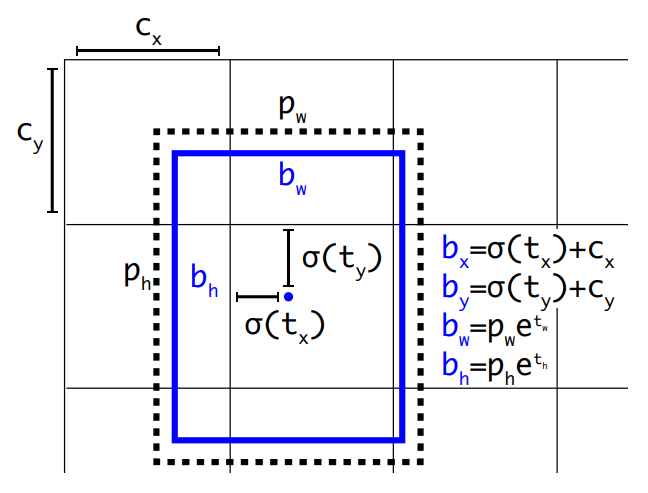

In [3]:
Image("yolov2.png", width="60%")

2. **Параметризация боксов внутри ячейки** $\newline$
   Каждая ячейка с индексом $(i,j)$ имеет смещение $(c_x, c_y)$ в сетке, $c_x, c_y$ $-$ индексы ячейки сетки по горизонтали и вертикали. Для якоря с нормированными относительно изображения размерами $(p_w,p_h)$ (якорь задается только 2 значениями) сеть предсказывает $t_x,t_y,t_w,t_h,t_o$:  
   - **Координаты центра бокса**:
     $$
       b_x = \sigma(t_x) + c_x,\quad
       b_y = \sigma(t_y) + c_y.
     $$  $\newline$
     Сигмоида $\sigma$ гарантирует, что центр остаётся внутри ячейки. $\newline$ 
   - **Ширина и высота бокса**:
     $$
       b_w = p_w \, e^{t_w},\quad
       b_h = p_h \, e^{t_h}.
     $$  $\newline$
     Экспонента обеспечивает положительность размеров и масштабирует их относительно якоря. $\newline$
   - **Уверенность бокса**:
     $$
       P(\text{object}) \times \mathrm{IoU} = \sigma(t_o).
     $$ $\newline$
   - **Пример**
   
        Индексы ячейки сетки: $c_x = 1$, $c_y = 0$.
       
        Нормализованные размеры якоря: $p_w = 0.2$, $p_h = 0.4$ (то есть якорь занимает 20% ширины и 40% высоты изображения).
        
        Предсказания нейронной сети (сырые выходные значения): $t_x = 0.5, t_y = 0.8, t_w = 0.3, t_h = -0.2$ $\newline$

        1.  **Координаты Центра Бокса**:
            * $b_x = \sigma(t_x) + c_x = 0.622 + 1 = 1.622$.
            * $b_y = \sigma(t_y) + c_y = 0.690 + 0 = 0.690$.

            Таким образом, **центр** предсказанного бокса находится в точке $(1.622, 0.690)$ относительно сетки ячеек. $\newline$

        2.  **Ширина и Высота Бокса**:
            * $b_w = p_w \cdot e^{t_w} = 0.2 \cdot 1.349 = 0.2698$.
            * $b_h = p_h \cdot e^{t_h} = 0.4 \cdot 0.819 = 0.3276$.

            Таким образом, **размеры** предсказанного бокса: ширина $0.2698$ (примерно 27% от ширины изображения) и высота $0.3276$ (примерно 33% от высоты изображения).
    
    Такой подход стабилизирует обучение на ранних этапах, так как якорь не может улететь в любую точку изображения. $\newline$

3. **Passthrough‑слой**  
   - Он берет карту признаков из более раннего слоя с высоким разрешением (26x26) и конкатенирует ее с финальной картой признаков (13x13). Это дает детектору доступ к более детальной информации для локализации мелких объектов. $\newline$

4. **Добавление BatchNorm слоев** $\newline$

5. **Использование k-means кластеризации** 

    - Есть необходимость выбрать размеры для якорных боксов, так как для каждой задачи эти размеры индивидуальны. Например, для обнаружения жирафов нужны высокие якорные боксы, для обнаружения машин - широкие якорные боксы. Вместо ручного подбора, авторы применили k-means кластеризацию к размерам всех рамок из обучающего датасета, чтобы найти самые типичные формы объектов.

### Зачем использовать якорные боксы?

- **YOLOv1** не умела предсказывать больше одного бокса на одну ячейку. Для того, чтобы научиться предсказывать несколько боксов для каждой ячейки, не обязательно вводить якорные боксы, так как в архитектуре **YOLOv1** можно было изменить предсказание для ячейки с $B×5 + C$ на $B×(5 + C)$, но такой подход оказался бы неэффективным. $\newline$

- Предположим, что модель **YOLOv1** работает по принципу $B×(5 + C)$, то есть может предсказывать несколько боксов на каждую ячейку. Пусть $B=5$, в таком случае все 5 предсказателей в ячейке будут "драться" друг с другом за право предсказывать один и тот же объект. Они не смогут выработать стабильную специализацию. Один и тот же предсказатель будет то пытаться предсказать машину, то пешехода, и его веса будут хаотично меняться. Обучение будет невероятно долгим и, скорее всего, не сойдется к хорошему результату. $\newline$

- С якорями (как в **YOLOv2**) модель с самого начала знает: "Предсказатель №1 связан с высоким и узким якорем, он должен искать пешеходов. Предсказатель №2 связан с широким якорем, он должен искать машины". Получается, что модели нужно научиться предсказывать лишь небольшие поправки к уже существующим, хорошим шаблонам. Это гораздо более простая и стабильная регрессионная задача. "Драки" между предсказателями не происходит. Если в ячейке есть машина, ее с высокой вероятностью будет обрабатывать тот предсказатель, чей якорь-шаблон больше всего похож на машину. $\newline$

- Именно поэтому ключевая разница не в том, что технически невозможно предсказать несколько боксов без якорей, а в том, что якоря делают этот процесс стабильным, эффективным и осмысленным. $\newline$

# [YOLOv3](https://arxiv.org/abs/1804.02767)

### Основные улучшения над YOLOv2

1. **Использование ResNet подобной backbone сети**

    - Была увеличена глубина сети за счет добавления **skip connections**. $\newline$

2. **Предсказания на 3 различных масштабах**

    - **Первый масштаб.** Сеть backbone обрабатывает входное изображение. На последнем слое делается первое предсказание. $\newline$
    - **Второй масштаб.** Берётся карта признаков из предыдущего шага (13x13). Она увеличивается в 2 раза (upsampling) до размера 26x26. Затем берётся карта признаков из более раннего слоя backbone (которая имеет размер 26x26 и более высокое пространственное разрешение) и конкатенируется (склеивается) с увеличенной картой. Эта объединённая карта пропускается через несколько свёрточных слоёв, и на выходе делается предсказание на сетке 26x26. $\newline$
    - **Третий масштаб.** Процедура повторяется еще раз. Берётся карта признаков со второго этапа (26x26), увеличивается до 52x52, конкатенируется с еще более ранней картой признаков. После нескольких свёрток делаются финальные предсказания на сетке 52x52. Высокое разрешение этой карты позволяет уверенно обнаруживать даже самые мелкие объекты, так как на более ранних слоях больше информации о деталях. 

    В **YOLOv2** была одна-единственная сетка $13×13$. В **YOLOv3** же предсказания делаются для 3 сеток разного разрешения: $13×13,$ $26×26,$ $52×52.$ $\newline$

3. **Новый подход к якорным рамкам**

    - Вместо 5 якорей, как в **YOLOv2**, теперь используется 9. Эти 9 якорей разделены между тремя масштабами предсказаний: 3 якоря (самые большие) используются на сетке 13x13 для обнаружения крупных объектов, 3 якоря (среднего размера) используются на сетке 26x26, 3 якоря (самые маленькие) используются на сетке 52x52 для обнаружения мелких объектов.
   
    Как и в **YOLOv2**, размеры этих якорей по-прежнему определяются с помощью **k-means** кластеризации на размерах всех ограничивающих рамок из обучающего набора данных.

# [YOLOv4](https://arxiv.org/abs/2004.10934)

### Основные улучшения над YOLOv3

1. **Улучшенный backbone**
    - Новый архитектурный подход, который разделяет поток каналов признаков на две части. Одна часть проходит через блок сверточных слоёв, а другая — напрямую соединяется с концом блока. $\newline$

2. **Добавление SPP + PANet**

    - **SPP (Spatial Pyramid Pooling).** Рецептивное поле — это область на исходном изображении, которую "видит" один нейрон на карте признаков. Чем оно больше, тем лучше модель понимает глобальный контекст. Цель **SPP** - значительно увеличить рецептивное поле. **SPP** берёт карту признаков с последнего слоя. Эта карта пропускается параллельно через несколько слоёв **Max-Pooling** с разным размером ядра (**kernel size**). В **YOLOv4** используются ядра размером $k×k$, где $k=\{1, 5, 9, 13\}$ + используется **padding="same"**, чтобы полученные карты признаков имели одинаковые разрешения. Результаты всех этих **Max-Pooling** операций конкатенируются (склеиваются) в одну большую карту признаков. 
        
        &emsp;&emsp;В итоге, каждый пиксель на выходной карте **SPP** "знает" о контексте вокруг себя в четырех разных масштабах одновременно, что делает модель крайне устойчивой к разным размерам объектов.$\newline$
    - **PANet (Path Aggregation Network).** **PANet** — это более продвинутая альтернатива **FPN** (Feature Pyramid Network). **YOLOv4** берет карту признаков из глубокого слоя (где признаки семантически богатые, но пространственно грубые), увеличивает её (upsampling) и объединяет (конкатенирует) с картой признаков из более раннего слоя. Это позволяет передать информацию о том, "что" за объект, на уровни, где есть точная информация о том, "где" он находится. Этот процесс повторяется для нескольких масштабов.
    
         &emsp;&emsp;После того, как признаки были обогащены семантикой на пути "сверху-вниз", **PANet** добавляет ещё один путь. **PANet** берет объединенную, обогащенную (семантика + детали) карту признаков с большим количеством деталей из ранних слоев с самым высоким разрешением и объединяет (конкатенирует) ее с признаками из более глубоких слоев. Для того, чтобы карты признаков из ранних слоев могли быть объединены с более глубокими слоями, их размер необходимо уменьшить. Для этого используются свертки с шагом (stride) больше 1 (например, 2x2). Это позволяет свертке не только извлекать признаки, но и одновременно уменьшать пространственное разрешение карты признаков. 
         
         &emsp;&emsp;Это гарантирует, что даже самые глубокие слои, предсказывающие крупные объекты, получают самые точные данные о контурах и местоположении, что делает локализацию всех объектов более точной.

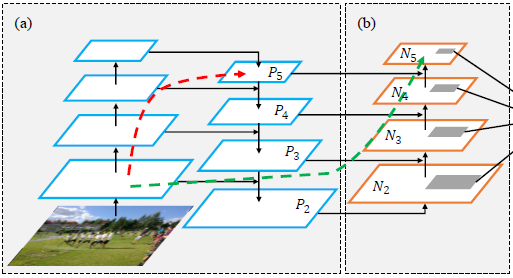

In [4]:
Image("PANet.png", width="60%")

3. **Добавление новых аугментации**

    - **Mosaic Data Augmentation.** Новая техника аугментации, которая смешивает 4 разных изображения в одно. $\newline$
    
    - **Class Label Smoothing.** Преобразование "жёстких" меток (0 и 1) в "мягкие" (например, 0.9 и 0.1). Это предотвращает "переобучение" и излишнюю уверенность модели в своих предсказаниях, заставляя ее лучше обобщать данные и быть более устойчивой к шуму в разметке. $\newline$

4. **Новая Loss функция**

    - Общая функция потерь **YOLOv4** является суммой трех компонентов: 
    
    $$Loss = L_{box} + L_{obj} + L_{cls}$$
    
    - $L_{obj}$ - **потери для уверенности в наличии объекта**
    
      Используется бинарная перекрестная энтропия (**BCE Loss**). Пример того, как она может выглядеть:
      
      $$L_{obj} = -\sum_{i=0}^{S^2}\sum_{j=0}^{B}I_{ij}^{obj}\log(\hat{o}_{ij}) - \sum_{i=0}^{S^2}\sum_{j=0}^{B}I_{ij}^{noobj}\log(1-\hat{o}_{ij})$$

        $S^2$ — количество ячеек в сетке.
        
        $B$ — количество якорей на ячейку.
        
        $I_{ij}^{obj}$ — это индикатор. Он равен $1$, если $j$-й якорь в $i$-й ячейке "ответственен" за объект, и $0$ в противном случае.
        
        $I_{ij}^{noobj}$ — индикатор, который равен $1$, если якорь не соответствует объекту.
        
        $\hat{o}_{ij}$ — это предсказанная моделью "уверенность" (число от $0$ до $1$).
        
        Как работает: Формула состоит из двух частей. Первая часть работает, когда в рамке **есть** объект ($I_{ij}^{obj}=1$): она заставляет предсказание $\hat{o}_{ij}$ стремиться к $1$. Вторая часть работает, когда в рамке **нет** объекта ($I_{ij}^{noobj}=1$): она заставляет $\hat{o}_{ij}$ стремиться к $0$.
        
      ---
      
      $L_{class}$ - **потери классификации**
    
      Это тоже **BCE Loss**, но применяется для каждого класса отдельно. Пример того, как она может выглядеть:
      
      $$L_{class} = -\sum_{i=0}^{S^2}\sum_{j=0}^{B}I_{ij}^{obj}\sum_{c \in classes}[p_{ij}(c)\log(\hat{p}_{ij}(c)) + (1-p_{ij}(c))\log(1-\hat{p}_{ij}(c))]$$

        $I_{ij}^{obj}$ — тот же индикатор. Эта ошибка считается **только если в рамке есть объект**.
        
        Внутренняя сумма $\sum_{c \in classes}$ пробегается по всем возможным классам.
        
        $p_{ij}(c)$ — это истинная метка для класса $c$ ($1$, если объект принадлежит этому классу, иначе $0$. В **YOLOv4** это значение "смягчается" техникой **Class Label Smoothing**).
        
        $\hat{p}_{ij}(c)$ — предсказанная моделью вероятность для класса $c$.
        
        Как работает: Для каждого класса модель пытается предсказать $1$ (если это правильный класс) или $0$ (если неправильный), и ВСЕ штрафует её за ошибки.
      
      ---
    
    - $L_{box}$ — **потери для Bounding Box (CIoU Loss)**
    
      $$L_{box} = 1 - IoU + \frac{\rho^2(b, b^{gt})}{c^2} + \alpha v$$
      
      где **IoU** (Intersection over Union) рассчитывается как: 
      
      $$IoU = \frac{|A \cap B|}{|A \cup B|}$$
      
      Здесь $A$ и $B$ — это предсказанная и истинная ограничивающие рамки, а $|A \cap B|$ и $|A \cup B|$ — площади их пересечения и объединения  соответственно.
      
      Мы хотим, чтобы перекрытие между предсказанной и истинной рамками было максимальным. Поэтому, чтобы минимизировать потерю, мы берем $1−IoU$. Если $IoU$ равен $1$ (идеальное совпадение), то $1−IoU=0$ (идеальная потеря). Если $IoU$ равен $0$ (нет перекрытия), то $1−IoU=1$ (большая потеря). Это заставляет модель "двигать" предсказанную рамку к истинной, пока они не начнут перекрываться.
      
      &emsp;&emsp;$\rho^2(b, b^{gt})$ — это **квадрат евклидова расстояния** между центральными точками предсказанной рамки $b$ и истинной рамки $b^{gt}$. Чем дальше центры друг от друга, тем больше это значение.
      
      &emsp;&emsp;Этот член штрафует за удаленность центров рамок. Если центры находятся рядом, этот член будет маленьким. Если центры далеко друг от друга, этот член будет большим, увеличивая потерю. Это помогает модели не просто найти перекрытие, но и сдвинуть предсказанную рамку так, чтобы её центр был как можно ближе к центру истинной рамки.
      
      &emsp;&emsp;$c^2$ — квадрат длины диагонали наименьшего охватывающего прямоугольника, который включает обе рамки (как предсказанную, так и истинную). Когда рамки далеки друг от друга (низкий IoU), охватывающий прямоугольник (и, следовательно, c) будет большим. В этом случае, даже если $\rho^2(b, b^{gt})$ (расстояние между центрами) тоже большое, деление на большой $c^2$ уменьшит относительный штраф. Этот множитель нужен, чтобы на ранних этапах обучения, когда рамки еще очень далеки, модель сначала фокусировалась на перемещении рамок к перекрытию, а не на идеальном совмещении центров.
      
      &emsp;&emsp;$v$ — мера того, насколько сильно соотношения сторон (ширина/высота) предсказанной и истинной рамок отличаются.
      
      $$v = \frac{4}{\pi^2} \left( \arctan\left(\frac{w^{gt}}{h^{gt}}\right) - \arctan\left(\frac{w}{h}\right) \right)^2$$
      
      &emsp;&emsp;Используется $arctan$, потому что он хорошо работает с соотношениями и "сглаживает" большие изменения, а квадрат делает штраф всегда положительным. Где $w, h$ — ширина и высота предсказанной рамки, а $w^{gt}, h^{gt}$ — ширина и высота истинной рамки. Функция $arctan(x)$ при $x > 0$ (соотношение сторон положительно) имеет диапазон значений $(0, \,\frac{π}{2})$. Использование $arctan$ нормализует и ограничивает значения соотношений сторон, предотвращая получение экстремально больших штрафов за небольшие изменения, когда $\frac{w}{h}$ очень велико. Еще одно положительное свойство функции $arctan$ в том, что она одинаково чувствительна к отклонениям от квадратной рамки как в сторону очень высоких, так и в сторону очень широких рамок.
      
      &emsp;&emsp;$\alpha$ — динамический весовой коэффициент, который определяет, насколько сильно мы должны учитывать штраф $v$. Этот весовой коэффициент придаёт этому штрафу меньший приоритет, когда **IoU** низкий (сначала важнее сблизить рамки, а потом уже подгонять форму).
      
      $$\alpha = \frac{v}{(1 - IoU) + v}$$

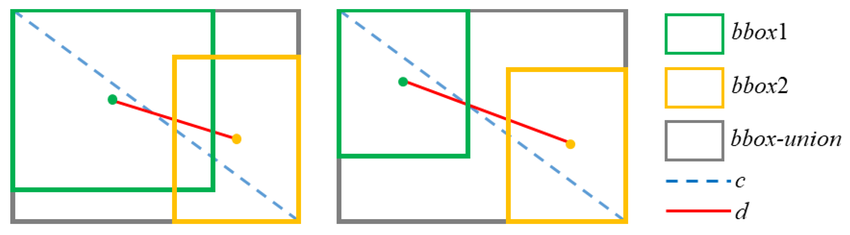

In [8]:
Image("CIoU.png", width="70%")

# YOLOv5

### Основные улучшения над YOLOv4

1. YOLOv4 написана на кастомном фреймворке Darknet. YOLOv5 полностью реализована на PyTorch, что дает простоту в установке и использовании. $\newline$

2. В YOLOv4 якорные рамки были статичными, рассчитанными заранее на датасете COCO. В YOLOv5 встроен механизм, который перед каждым обучением автоматически анализирует собственный набор данных и вычисляет оптимальные размеры якорей. $\newline$

3. Добавлено семейство моделей (n, s, m, l, x) на выбор. 

# [YOLOv8](https://www.arxiv.org/abs/2305.09972v2?conversation_id=68765b4b7f525f99d53c4b76)

## Архитектура и модули YOLOv8

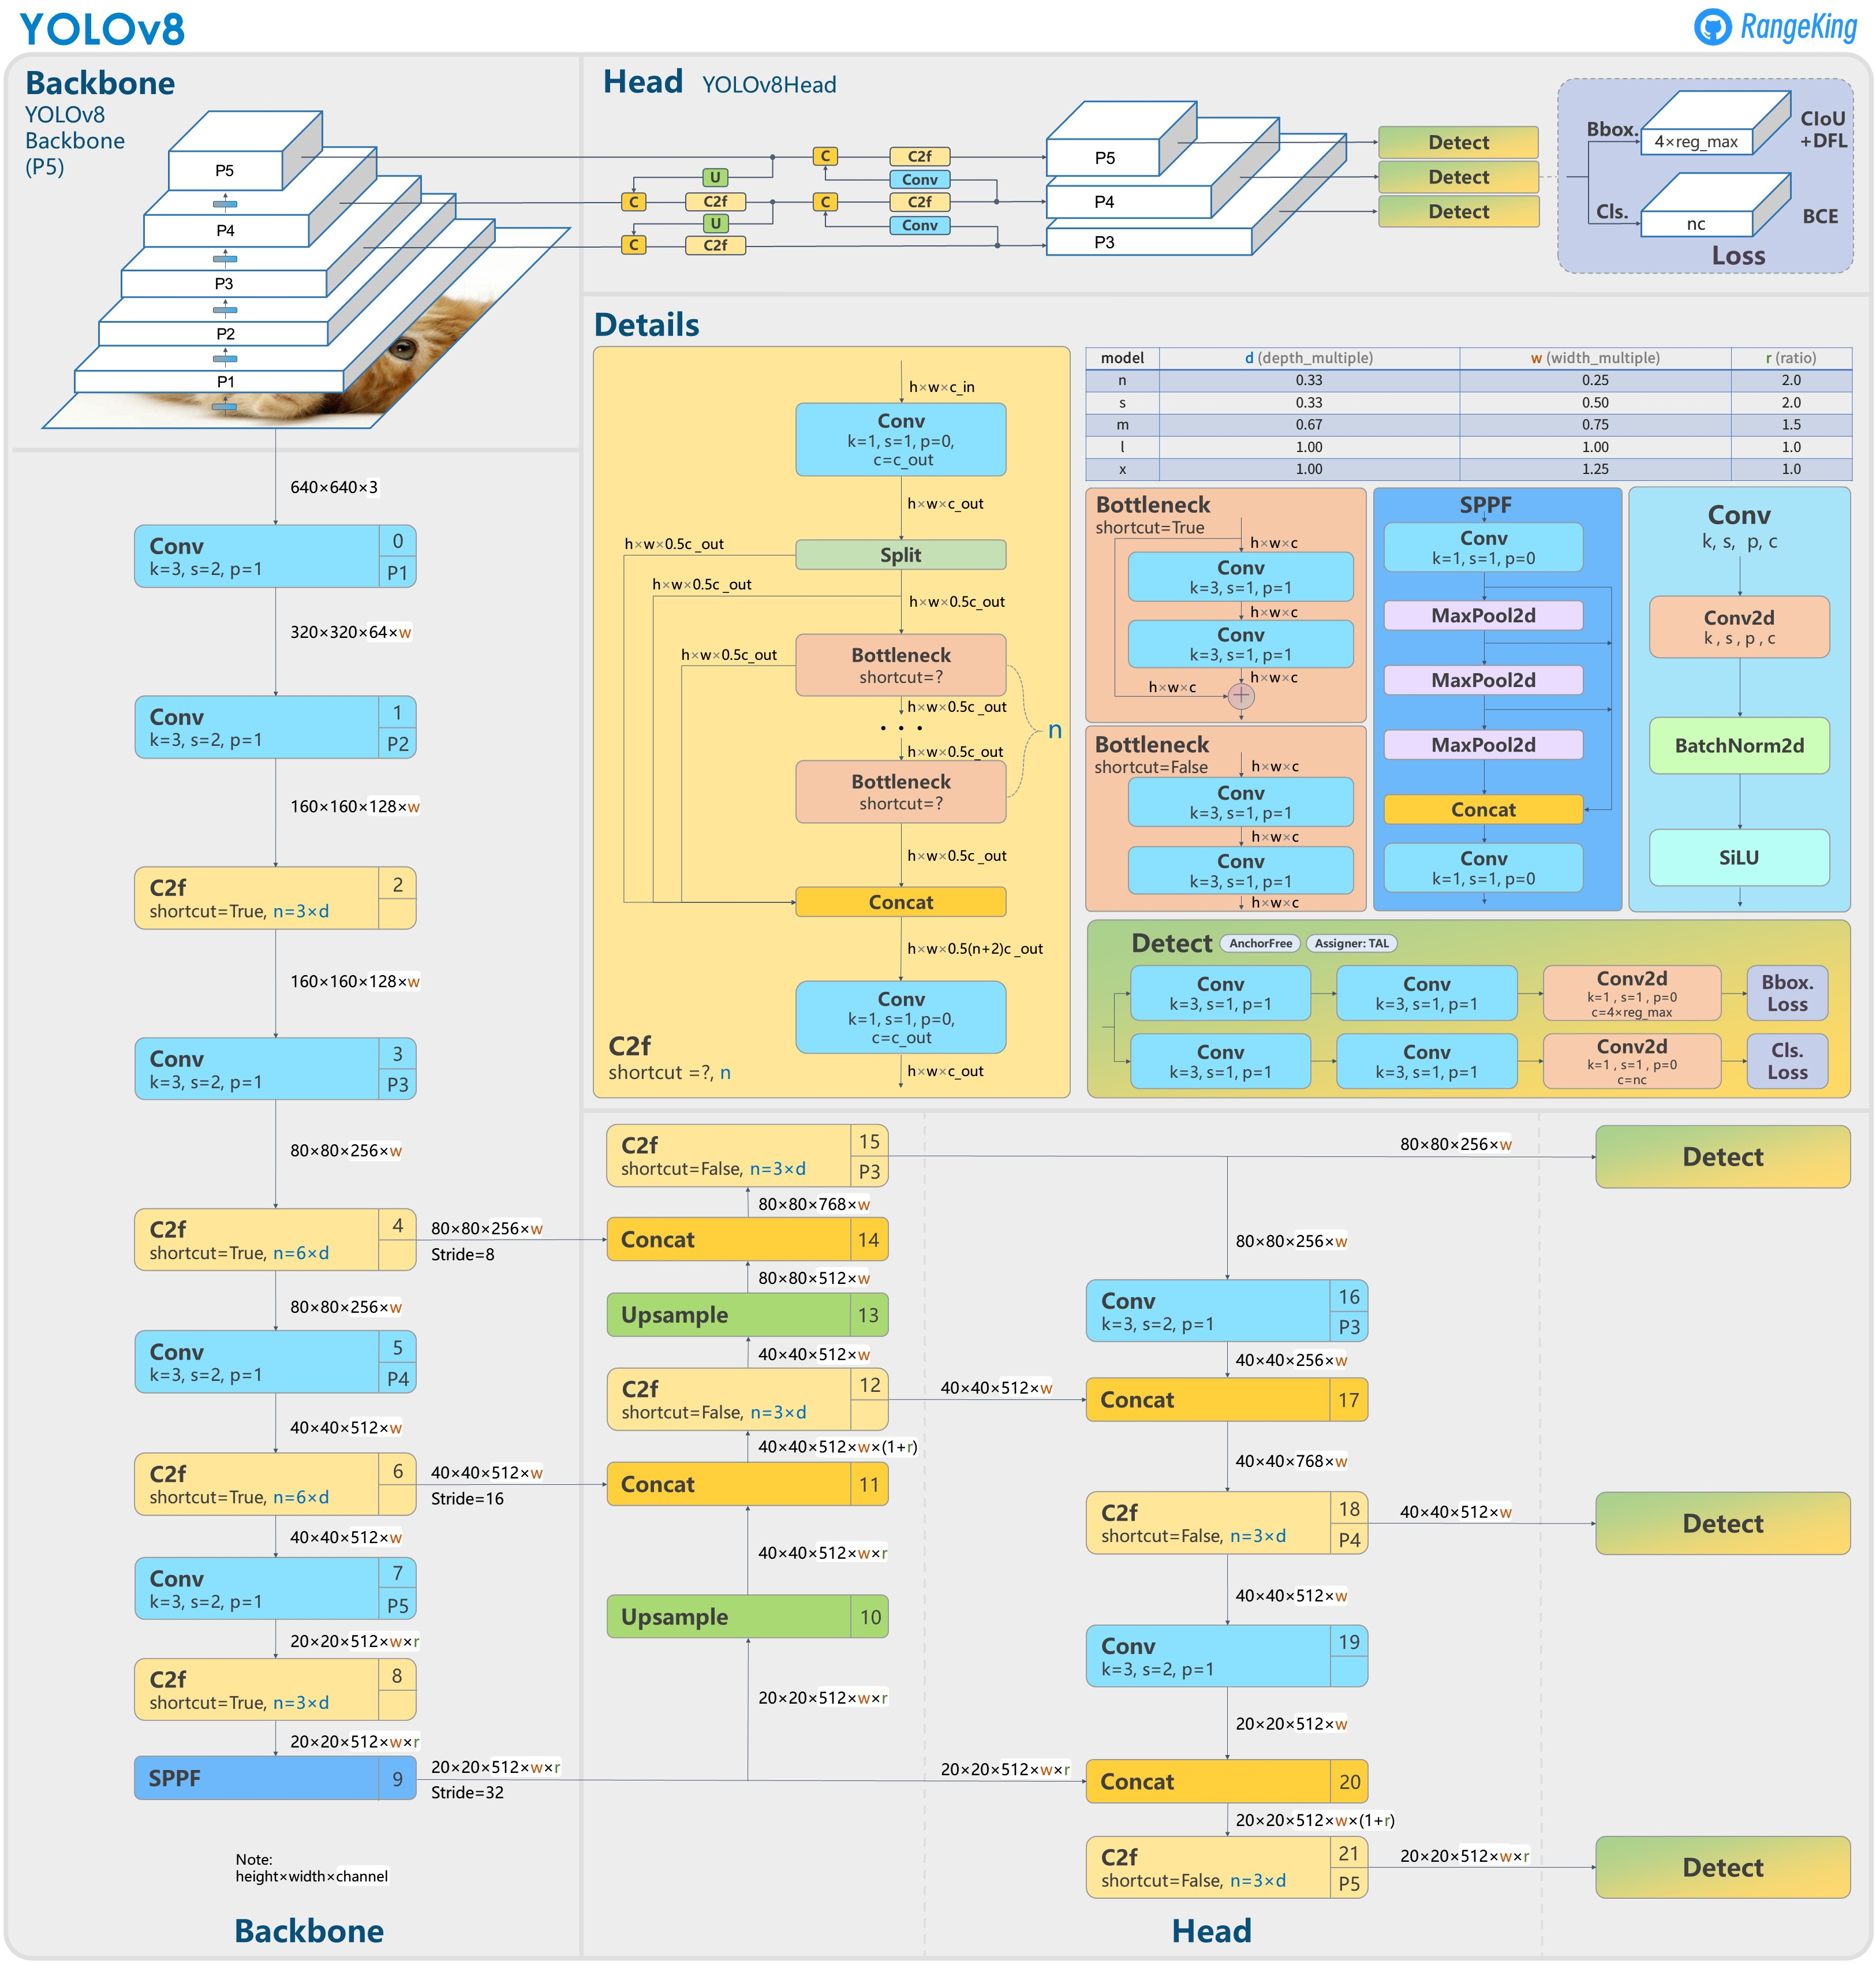

In [59]:
Image("yolov8.jpg", width="95%")

## Возможный [вид](https://github.com/autogyro/yolo-V8/blob/main/ultralytics/nn/modules.py) модулей YOLOv8

In [46]:
class Conv(nn.Module):
    def __init__(self, c_in, c_out, k=1, s=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, k, s, padding=k//2, bias=False)
        self.bn = nn.BatchNorm2d(c_out)
        self.act = nn.SiLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
    

class Bottleneck(nn.Module):
    def __init__(self, c, shortcut=True):
        super().__init__()
        self.cv1 = Conv(c, c//2, k=3)
        self.cv2 = Conv(c//2, c, k=3)
        self.shortcut = shortcut
    
    def forward(self, x):
        out = self.cv2(self.cv1(x))
        out = x + out if self.shortcut else out
        return out

    
class C2f(nn.Module):
    def __init__(self, c_in, c_out, n, shortcut=True):
        super().__init__()
        e = 0.5
        self.split_channels = int(c_out * e)
        self.cv1 = Conv(c_in, c_out)
        self.cv2 = Conv((n+2) * self.split_channels, c_out)
        self.mb = nn.ModuleList(Bottleneck(self.split_channels, shortcut) for _ in range(n))
    
    def forward(self, x):
        out = self.cv1(x)
        split1, current = out.split(self.split_channels, dim=1)
        tensors_to_concat = [split1, current]
        
        for b in self.mb:
            current = b(current) 
            tensors_to_concat.append(current)
            
        concat_tensor = torch.cat(tensors_to_concat, dim=1)
        return self.cv2(concat_tensor)
    
    
class SPPF(nn.Module):
    def __init__(self, c_in, c_out, k=5):
        super().__init__()
        self.c = c_in // 2
        self.cv1 = Conv(c_in, self.c)
        self.cv2 = Conv(self.c * 4, c_out)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
        
    def forward(self, x):
        out = self.cv1(x)
        tensors_to_concat = [out]
        
        for _ in range(3):
            out = self.m(out)
            tensors_to_concat.append(out)
        
        concat_tensor = torch.cat(tensors_to_concat, dim=1)
        return self.cv2(concat_tensor)

## Принцип работы YOLOv8



1. **Изображение пропускается через Backbone.**

    - Основные составляющие: `Conv`, `Bottleneck` и `C2f` модули. $\newline$
    
    - Модуль `C2f`. Основной строительный блок архитектуры. В ней входной тензор разделяется пополам по оси каналов. Одна половина идёт дальше напрямую. Вторая половина проходит через последовательность блоков `Bottleneck`. Выходы из этих блоков конкатенируются друг с другом в единый большой тензор. После этого объединённый тензор сливается с первой половиной, которая шла напрямую. В конце применяется блок `Conv` с `kernel_size=1`, чтобы уменьшить число каналов. $\newline$
    
2. **Карта признаков из Backbone проходит через SPPF + FPN + PANet.**

    - Модуль `SPPF`. Это более быстрая версия `SPP` из `YOLOv4`. Вместо параллельных `Max-Pooling` с разными ядрами (5x5, 9x9, 13x13), `SPPF` использует три последовательных `Max-Pooling` с ядром 5x5. Это даёт идентичное по рецептивному полю, но более быстрое вычисление. $\newline$
    
    - Модуль `FPN + PANet`. Используется архитектура, как и в `YOLOv4/v5`, но в качестве строительных блоков используются модули `C2f`. В `FPN` берутся признаки из глубоких слоёв **Backbone**, увеличиваются (`Upsample`) и сливаются с признаками из более ранних слоёв. В `PANet` добавляется еще один путь в обратном направлении, по которому информация о точной локализации передается  обратно в сторону более глубоких слоев. Это помогает точнее определять местоположение мелких объектов. (**более подробно на изображении сверху и в описании YOLOv4**) $\newline$ 

3. **Ветка регрессии и классификации.**

    - На выходе из 2 пункта получаются 3 карты признаков разного размера, поэтому предсказания делаются не для одной карты признаков, а для 3 сразу, причем, для каждой карты признаков теперь используются раздельные ветки регрессии и классификации. В `YOLOv8` отказались от якорей. $\newline$ 
    
    - **Ветка классификации.** Для каждой ячейки на карте признаков генерируется вектор предсказаний размерности равной числу классов. Например, если всего 80 классов, это будет вектор из 80 чисел. К вектору классификации применяется функция `Sigmoid`. Она превращает логиты в вероятности от 0 до 1 для каждого класса.$\newline$ 
    
    - **Ветка регрессии.** `YOLOv8` использует Anchor-Free подход. Модель больше не предсказывает 4 смещения + 1 уверенность. В новой версии модели предсказываются 4 значения (вектора), представляющие собой распределение вероятностей для расстоянии от центра ячейки до четырёх сторон рамки. Например, если `reg_max=16` (размер вектора), то для предсказания расстояния до верхней границы модель выдаст 16 чисел. Таким образом, вектор регрессии имеет длину `4 * reg_max`. 
    
        &emsp;&emsp;Регрессионная голова для каждой ячейки сетки на выходе даёт тензор глубиной 4 * 16 = 64 канала. Эти 64 канала интерпретируются как 4 независимых вектора по 16 значений для каждой из сторон. К каждому из 4-х векторов применяется `Softmax`, чтобы получить 4 распределения вероятностей. Получаются 4 вектора распределения вероятностей, сумма каждой равна 1. Для каждой вероятности в таком векторе соответствует расстояние. В случае `reg_max=16` эти растояния примут вид `[0, 1, 2, ..., 15]`. Каждое значение в этом векторе соответствует расстоянию от центра ячейки, которое измеряется в единицах, кратных шагу (`stride`) текущей карты признаков.
        
        &emsp;&emsp;Каждая (всего 3) карта признаков модели имеет свой шаг относительно **исходного изображения**. Например, карта признаков с большим разрешением (для мелких объектов) для изображения размера 640x640 и полученной карты признаков 80x80 имеет шаг (`stride`) = 8 (640 / 80 = 8). Таким образом, каждое значение в векторе `[0, 1, 2, ..., 15]` измеряется в единицах `stride`. То есть в нашем примере для 2 элемента вектора расстояние в пикселях было бы `2 * stride = 2 * 8 = 16`. 
        
        &emsp;&emsp;Важно отметить, одна ячейка на одной конкретной карте признаков имеет ограниченный радиус действия. Ячейка на карте со `stride=16` не может предсказать рамку, граница которой находится дальше 240 пикселей от центра этой ячейки, так как 16 * 15 = 240 (максимальное расстояние при `reg_max=16`), но это не проблема, так как существует карта признаков с маленьким разрешением, например, в 20x20 ячеек со `stride=32`. На такой карте признаков в случае `reg_max=16` можно легко предсказать даже объект, который занимает почти всё изображение.
        
        &emsp;&emsp;В конце получаются вектор значении растояния от центра `[0, 1, 2, ..., 15]`, которая измеряется в единицах `stride`, и 4 группы векторов распределения вероятностей для каждого направления. То есть для значения 0 соответствует $p_0$, для 1 соответствует $p_1$ и так далее. Во время инференса итоговые расстояния от центра ячейки до каждой из 4 сторон бокса вычисляются как "математическое ожидание" по формуле: $$Distance = \sum_{i=0}^{reg\_max-1}i \,\cdot p_i=0 \cdot p_0 + 1 \cdot p_1 \,+ ... + \,(reg\_max-1) \cdot p_{reg\_max-1}$$
        
        где $p_i$ — вероятность, полученная после `Softmax`. 
        
        &emsp;&emsp;В итоге мы получаем 4 расстояния от центра ячейки: `top`, `bottom`, `left` и `right`. Зная значение `stride` для конкретной карты признаков, легко получить расстояния в пикселях для 4 полученных значений. Таким образом, `YOLOv8` как бы говорит: "Вместо того, чтобы предсказывать одно-единственное число для координаты, давай ты предскажешь распределение вероятностей того, где эта координата может находиться. А мы уже из этого распределения найдем точное значение." $\newline$ 

4. **Функция потерь.**

    - Общая функция потерь **YOLOv8** является суммой трех компонентов: 
    
    $$Loss = \lambda_{box} \cdot L_{box} + \lambda_{cls} \cdot L_{cls} + \lambda_{dfl} \cdot L_{dfl}$$
    
    ---
    
    - $L_{box}$ — **потери для Bounding Box (CIoU Loss)**
    
        Эта функция потерь была подробно описана при рассмотрении архитектуры `YOLOv4` выше, поэтому приводится только формула.
    
        $$L_{box} = \frac{1}{N_{pos}} \sum_{x,y} {I}_{x,y} \left( (1 - IoU_{x,y}) + \frac{\|b_{x,y} - \hat{b}_{x,y}\|_2^2}{c^2} + \alpha_{x,y}\nu_{x,y} \right);$$ 
        
        $N_{pos}$ — это количество "позитивных" ячеек;
        
        $\sum_{x,y}$ — сумма проходит по каждой ячейке (x, y) в этой сетке.
        
        ${I}_{x,y}$ — индикаторная функция. ${I}_{x,y}=1$ только для "позитивных" ячеек.  $\newline$   

    ---
        
    - $L_{cls}$ — **потери классификации (BCE Loss)** 
    
        Эта функция потерь была подробно описана при рассмотрении архитектуры `YOLOv4` выше, поэтому приводится только формула.
    
        $$L_{cls} = - \frac{1}{N_{pos}} \sum_{x,y} \left( \sum_{c \in classes} y_c \log(\hat{y}_c) + (1 - y_c)\log(1 - \hat{y}_c)\right);$$

    ---

    - $L_{dfl}$ — **Distribution Focal Loss (DFL)**

        $$L_{dfl} = \frac{1}{N_{pos}} \sum_{x,y} {I}_{x,y} \left( \sum_{k \in \{l,t,r,b\}} DFL\,(\,\hat{S}_{k, x, y}, \,y_{k, x, y}\,) \right);$$

        $$DFL\,(\,\hat{S}, y\,)=-\left((y_{i+1} - y) \log(\hat{S}_{i}) + (y - y_{i}) \log(\hat{S}_{i+1})\right);$$

        $\sum_{k \in \{l,t,r,b\}}$ — суммирование по четырём сторонам ограничивающей рамки: `l` (лево), `t` (верх), `r` (право), `b` (низ).
        
        $DFL\,(\,\hat{S}_{k, x, y}, \,y_{k, x, y}\,)$ — функция `Distribution Focal Loss` для одной конкретной стороны `k` (например, левой) для ячейки `(x, y)`.
        
        $\hat{S}_{k, x, y}$ — предсказанное распределение вероятностей (вектор) для расстояний стороны `k` в ячейке `(x, y)`.
        
        $y_{k, x, y}$ — реальное непрерывное значение расстояния.
        
        $DFL\,(\,\hat{S}, y\,)$ — основная формула `DFL`. Штрафует модель, если предсказанное распределение $\hat{S}$ не соответствует истинному непрерывному значению `y`.
        
        $y_{i}$ — нижняя ближайшая целая часть от `y`. Например, если `y = 2.7`, то $y_{i}=2$.
        
        $y_{i+1}$ — верхняя ближайшая целая часть от `y`. Например, если `y = 2.7`, то $y_{i+1}=3$.
        
        $\hat{S}_{i}$ — предсказанная вероятность (из распределения $\hat{S}$) для дискретного значения $y_{i}$.
        
        $\hat{S}_{i+1}$ — предсказанная вероятность (из распределения $\hat{S}$) для дискретного значения $y_{i+1}$.
        
        &emsp;&emsp;**Идея:** вместо того чтобы предсказывать одно число для координаты (например, расстояние до левой границы равно 15.3), модель предсказывает распределение вероятностей над набором целых чисел. Например, если реальное расстояние — 15.3, модель должна научиться предсказывать высокую вероятность для числа 15 и для числа 16. Модели легче научиться "размазывать" вероятность между двумя точками, чем предсказывать одно точное значение. Выход модели несёт в себе информацию о её "уверенности". Если распределение очень "острое" и сконцентрировано на одной точке, модель уверена. Если оно "размазано", она не уверена.
        
        &emsp;&emsp;**Как работает:** данная функция потерь заставляет модель сфокусировать ("Focal") основную массу вероятности на двух целых числах, окружающих реальное значение. Если `y=15.3`, то вес $(y - y_i) = 0.3$ будет приложен к логарифму вероятности $\hat{S}_{i+1}$, а вес $(y_{i+1} - y) = 0.7$ — к логарифму $\hat{S}_{i}$. Функция потерь применяет эти веса как "штрафы": она штрафует предсказание для $S_i$ с весом 0.7 и штрафует предсказание для $S_{i+1}$ с весом 0.3. Это заставляет модель "тянуть" распределение вероятности в сторону реального значения, так как конкретно в данном примере $DFL\,(\,\hat{S}, y\,)$ будет принимать минимум при $\hat{S}_{i}$ $>$ $\hat{S}_{i+1}$.
        
        &emsp;&emsp;**Важный момент:** при `reg_max=16` имеется вектор $\hat{S}$ размерности 16. Формула $-\left((y_{i+1} - y) \log(\hat{S}_{i}) + (y - y_{i}) \log(\hat{S}_{i+1})\right)$ учитывает только две вероятности $(\hat{S}_{i}, \hat{S}_{i+1})$ из 16-мерного вектора. Задача `DFL` — не просто найти правильное распределение, а научить модель предсказывать ненулевые вероятности только для двух точек, окружающих истинное значение, а все остальные 14 вероятностей должны стремиться к нулю.
        
        &emsp;&emsp;**Важный момент 2:** `YOLOv8` не предсказывает отдельную уверенность в наличии объекта (objectness), это избыточно. Теперь модель предсказывает только вероятности классов. Модель учится для фоновых областей предсказывать очень низкие вероятности для всех классов, если же в области есть объект, то как минимум одна из вероятностей должна быть высокой. Таким образом, максимальная вероятность по классам теперь сама по себе служит индикатором наличия объекта. Если модель ни в одном классе не уверена, значит, скорее всего, это фон. $\newline$
        
5. **TaskAlignedAssigner.**

    - **Во время обучения у нас есть:** $\newline$
    
        - Несколько реальных объектов на картинке (ground truth) $\newline$
        
        - Тысячи предсказаний, которые генерирует модель на трёх разных картах признаков. $\newline$

    - **Главный вопрос:** Какие из этих тысяч предсказаний считать "хорошими" (позитивными), а какие "плохими" (негативными)? Как сопоставить предсказание с реальным объектом? Если мы будем неправильно выбирать эти пары, модель будет учиться на некорректных примерах, и её точность будет низкой. $\newline$
    
    - **Как было раньше?** Позитивным считался только тот один якорь, у которого было самое большое `IoU` с реальным объектом. Это просто, но очень жёстко. Модель училась только на одном "идеальном" предсказании, игнорируя другие, тоже довольно хорошие. $\newline$
    
    - **В чем недостаток такого подхода?** В более ранних моделях полностью игнорировалось, насколько хорошо модель справляется с задачей классификации. Могло получиться так, что "позитивным" назначалось предсказание с идеальным `IoU`, но при этом модель была абсолютно не уверена, что это "кошка". $\newline$
    
    - **Новый подход в YOLOv8:** Основная идея `TaskAlignedAssigner` заключается в том, что "хорошее" предсказание должно быть хорошим сразу в обеих задачах: $\newline$
        
        - Оно должно точно локализовать объект (иметь высокий IoU). $\newline$
        
        - Оно должно уверенно классифицировать объект (иметь высокую вероятность правильного класса). $\newline$
        
    - **Алгоритм:** 
    
        **Шаг 1.** Сначала система строит матрицу, где для каждой пары (реальный объект i, предсказание j) вычисляются два значения:$\newline$
            
        - `IoU(i, j)` — Intersection over Union между рамкой объекта `i` и предсказанной рамкой `j`.$\newline$
        
        - `ClassScore(i, j)` — Вероятность, которую предсказание `j` дало для правильного класса объекта `i`. Например, если объект `i` — это "собака", мы берём из вектора предсказания `j` только значение для класса "собака". 
        
        **Шаг 2.** Две метрики из предыдущего шага объединяются в одну метрику, которая и показывает, насколько "хорош" кандидат:
        
        $$alignment\_metric = {ClassScore}^{\,\alpha} \cdot {IoU}^β$$
        
        `α` и `β` — это два гиперпараметра, которые контролируют баланс между важностью классификации и локализации.
        
        **Шаг 3.** Выбор `k` лучших кандидатов.
        
        Теперь для каждого реального объекта делается следующее: $\newline$
        
        - Смотрим на значения `alignment_metric`, вычисленные для него в паре со всеми предсказаниями. $\newline$
        
        - Сортируем все предсказания по убыванию этой метрики. $\newline$
        
        - Выбирает `k` предсказаний с самого верха списка, то есть предсказания с самыми высокими `alignment_metric`.
        
        Именно эти `k` предсказаний объявляются "позитивными" для данного реального объекта.
        
        **Шаг 4.** Разрешение конфликтов, если одно предсказание подходит нескольким объектам.
        
        Иногда одно и то же предсказание может попасть в `топ-k` сразу для двух близко расположенных реальных объектов. В этом случае, чтобы избежать путаницы, оно окончательно назначается тому реальному объекту, с которым у него наибольшее значение `IoU`.

# Использование YOLOv8

### Обучение модели

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.yaml")  # Сборка новой модели из YAML
model = YOLO('yolov8m.pt')    # Загрузка предварительно обученной модели

results = model.train(data="coco8.yaml", epochs=100, imgsz=640)

`model = YOLO("yolov8m.yaml")` — создает модель с нуля, используя только архитектуру, описанную в конфигурационном файле `yolov8m.yaml`. Модель, созданная таким образом, имеет случайно инициализированные веса.

`model = YOLO('yolov8m.pt')` — содержит не только архитектуру модели, но и ее веса, которые были получены после обучения на большом наборе данных.

### Обучение на нескольких GPU

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")  

# Обучение на 2 GPU
results = model.train(data="coco8.yaml", epochs=100, imgsz=640, device=[0, 1])

# Обучение с использованием одной самой свободной GPU
results = model.train(data="coco8.yaml", epochs=100, imgsz=640, device=-1)

# Обучение с использованием двух самых свободных GPU
results = model.train(data="coco8.yaml", epochs=100, imgsz=640, device=[-1, -1])

Обучение модели распределяется между несколькими `GPU` на одном компьютере.

`device=[0, 1]` — указывает, на каком оборудовании выполнять вычисления. Передача списка `[0, 1]` означает, что модель будет обучаться на `GPU` c `ID = 0` и `ID = 1`.

`device=[-1, -1]` — обеспечивает автоматический выбор наименее используемых `GPU` для обучения. 

<ins>Как понять, что на устройстве доступно несколько `GPU`?<ins>

Выполнить команду в терминале:  
    
```python
>>> nvidia-smi
```

### Возобновление прерванного обучения

In [ ]:
from ultralytics import YOLO

# Загружаем ЧАСТИЧНО обученную модель
model = YOLO("path/to/last.pt")  

# Возобновляем обучение
results = model.train(resume=True)

Позволяет продолжить обучение с того места, где оно было остановлено, чтобы не терять прогресс. 

Во время `model.train()` библиотека периодически сохраняет контрольные точки (checkpoints). Обычно это происходит в конце каждой эпохи. Эти чекпоинты сохраняются в папку с результатами. В этой папке есть два ключевых файла: `best.pt` (модель с лучшей метрикой на валидации) и `last.pt` (модель, сохраненная после самой последней завершенной эпохи).

Файл `last.pt` содержит не только веса модели, но и состояние оптимизатора, номер последней эпохи и состояние планировщика скорости обучения. При возобновлении обучения YOLO загружает `веса` из `last.pt`, восстанавливает состояние `оптимизатора`, состояние `learning rate scheduler` и `номер эпохи`.

Установив `resume=True`, метод `train` продолжит обучение с того места, где оно было прервано, используя состояние, хранящееся в файле `path/to/last.pt`. 
Если аргумент `resume` опущен или установлен в `False`, метод `train` начнет новый сеанс обучения, при этом YOLO использовал бы веса из `last.pt`, но начал бы обучение с 0-й эпохи и с новым состоянием оптимизатора.

### [Параметры обучения](https://docs.ultralytics.com/ru/modes/train/#train-settings)

`data` $:$ (`str`) — путь к файлу конфигурации набора данных (например, `data.yaml`). Этот файл содержит такие параметры, как пути к обучающим, валидационным и тестовым данным, названия классов и количество классов.

Cтруктура папок должна быть устроена подобным образом:

```shell
/my_yolo_project/
├── datasets/
│   └── example_dataset/
│       ├── images/
│       │   ├── train/
│       │   │   └── 001.jpg
│       │   └── val/
│       │       └── 101.jpg
│       └── labels/
│           ├── train/
│           │   └── 001.txt
│           └── val/
│               └── 101.txt
├── data.yaml  <-- НАШ ФАЙЛ КОНФИГУРАЦИИ
└── train.py   <-- НАШ СКРИПТ ОБУЧЕНИЯ
```

Вид `data.yaml` файла:

```yaml
path: datasets/example_dataset
train: images/train
val: images/val
test: images/test
nc: 3
names:
- person
- bicycle
- car
```

- `path` — путь относительно `data.yaml` к корневой папке датасета. Это **необязательное** поле, его можно убрать. Если его указать, то пути 
`(train, val, test)` можно будет писать относительно него. $\newline$

- `train, val, test` — относительные пути от `path` (если он указан) к обучающему, валидационному и тестовому выборкам. $\newline$

- `nc` — количество классов. $\newline$

- `names` — список названий классов. Индекс элемента в списке - это индекс класса (`class_index`). Например, `0 -> 'person'`, `1 -> 'bicycle'`, `2 -> 'car'` и так далее.

В файле `train.py` указывается путь к `data.yaml` относительно расположения этого файла:

```python
...
model.train(data='data.yaml', ...) 
...
```

Файлы в директории `labels` должны иметь вид (`class_index x_center y_center width height`) в каждой строке:
```python
0 0.50 0.55 0.30 0.50
1 0.25 0.30 0.20 0.15
1 0.75 0.60 0.40 0.25
2 0.40 0.80 0.10 0.12
```

Каждая строка — отдельная рамка. Координаты должны быть нормализованы к диапазону от 0 до 1 и быть в формате `YOLO`. 

---

`epochs` $:$ (`int`) — количество эпох обучения.

---

`batch` $:$ (`int, float`) — размер батча. 

Всего 3 режима: 

- `batch = int`. Например, `batch=16` — на каждом шаге обучения модель будет обрабатывать ровно 16 изображений. $\newline$

- `batch = -1` — автоматически подбирает размер батча так, чтобы использовалось 60% памяти `GPU`. $\newline$

- `batch = float` — автоматически подбирает размер батча так, чтобы использовалась указанная доля памяти `GPU`. $\newline$

--- 

`imgsz` $:$ (`int, list`) — размер изображения для обучения. Если значение типа `int`, то YOLO преобразует исходное изображение в квадратное изображение размера `imgsz x imgsz`.

Например, если `imgsz=640`, то происходит следующее:

- Берется исходное изображение (например, 1920x1080).$\newline$

- Оно изменяется в размере так, чтобы его большая сторона стала равна 640 пикселей, при этом сохраняются пропорции. В нашем примере оно станет 640x360.$\newline$

- Оставшееся пространство заполняется серыми полосами (padding), чтобы итоговый размер стал 640x640.

---

`device` $:$ (`int, str, list`) — указывает вычислительное устройство для обучения: один GPU (`device=0`), несколько GPU (`device=[0, 1]`), CPU (`device='cpu'`), для Apple silicon (`device='mps'`) или автоматический выбор наиболее простаивающего GPU (`device=-1`) или несколько простаивающих GPU (`device=[-1, -1]`).

---

`optimizer`  $:$ (`str`) — выбор оптимизатора для обучения. Возможные варианты: `SGD`, `Adam`, `AdamW`, `NAdam`, `RAdam`, `RMSProp` или `auto` — автоматически выбирает оптимальный оптимизатор.

--- 

`lr0` $:$ (`float`) — начальная скорость обучения (learning rate).

`lrf` $:$ (`float`) — конечная скорость обучения (learning rate), как доля от начальной скорости. `lrf = lr0 * lrf`.

---

`cos_lr` $:$ (`bool`) — использует `cosine learning rate scheduler`, регулируя `learning rate` в соответствии с косинусоидальной кривой.

---

`weight_decay` $:$ (`float`) — L2 регуляризация, для борьбы с переобучением.

---

$$Loss = \lambda_{box} \cdot L_{box} + \lambda_{cls} \cdot L_{cls} + \lambda_{dfl} \cdot L_{dfl}$$

`box` $:$ (`float`) — вес компоненты функции потерь $ L_{box}$.

`cls` $:$ (`float`) — вес компоненты функции потерь $ L_{cls}$.

`dfl` $:$ (`float`) — вес компоненты функции потерь $ L_{dfl}$.

---

`fraction` $:$ (`float`) — указывает, какую долю от `тренировочного` датасета использовать для обучения. Полезно для проверки, что код запускается без ошибок, или подбора гиперпараметров на меньшем датасете. 

---

`cache`  $:$ (`bool, str`) — ускоряет обучение путем кэширования изображений в памяти. По умолчанию = `False`, то есть выключен. Можно включить с помощью `cache=True` или `cache='ram'`, чтобы кэширование происходило в оперативной памяти (самый быстрый, но требует, чтобы было достаточно RAM) и `cache='disk'`, чтобы кэширование происходило на диске.

---

`time` $:$ (`float`) — максимальное время обучения в часах, позволяющий автоматически остановить обучение по истечении указанного времени. Если задано, оно отменяет значение `epochs`. 

--- 

`patience` $:$ (`int`) — количество эпох без улучшения метрики, посчитанная на валидационной выборке, после которого обучение будет досрочно остановлено. 

---

`save` $:$ (`bool`) — разрешает (включает) сохранение контрольных точек обучения и весов окончательной модели.

Во время обучения всегда сохраняются два файла, которые перезаписываются каждую эпоху:

- `last.pt`: веса модели после последней завершенной эпохи.$\newline$

- `best.pt`: веса модели, показавшей лучший результат на валидационной выборке за все время обучения.

`save_period` $:$ (`int`) — частота сохранения контрольных точек модели, заданная в эпохах. Если `save_period=10`, то помимо `last.pt` и `best.pt`, в папке с весами будут создаваться файлы `epoch0.pt`, `epoch10.pt`, `epoch20.pt` и так далее.

---

`project` $:$ (`str`) — cоздает основную папку для проекта, в котором сохраняются результаты обучения.

`name` $:$ (`str`) — имя папки конкретного запуска обучения, которая создается внутри директорий `project`. Туда будут сохранены результаты обучения.

`exist_ok` $:$ (`bool`) — если `exist_ok=True`, разрешает перезапись существующего каталога `project/name`. Если `exist_ok=False`, то при попытке запуска обучения с теми же `project` и `name` еще раз, библиотека выдаст ошибку, чтобы прошлые результаты случайно не затерлись. 

---

`single_cls` $:$ (`bool`) — рассматривает все классы в наборе данных как один класс во время обучения. Полезно для задач бинарной классификации или когда основное внимание уделяется наличию объекта, а не классификации. Например, вам нужно просто находить "дефекты" на поверхности, и не важно, какой это тип дефекта.

---

`classes` $:$ (`list[int]`) — указывает список индексов классов для обучения. Вместо того, чтобы вручную создавать новый датасет и удалять из него все лишние метки, можно использовать параметр `classes`.

YOLO будет загружать данные и смотреть на файлы разметки (`.txt`). Он будет полностью игнорировать все строки, где указаны любые другие классы, кроме тех, что перечислены в `classes`.

---

`close_mosaic` $:$ (`int`) — отключает мозаичную аугментацию данных в последние N эпох для стабилизации обучения перед завершением. Установка значения 0 отключает эту функцию.

---

`freeze` $:$ (`int, list`) — замораживает первые N слоев модели или указанные слои по индексам в списке, уменьшая количество обучаемых параметров.

---

`momentum` $:$ (`float`) — значение импульса для `SGD` или параметра для оптимизаторов `Adam`, влияющий на включение прошлых градиентов в текущее обновление.

---

`warmup_epochs` $:$ (`float`) — количество эпох для разогрева скорости обучения. Постепенно увеличивая скорость обучения с низкого значения до начальной скорости обучения происходит стабилизация обучения на ранней стадии.

---

`plots` $:$ (`bool`) — включает генерацию дополнительных, очень подробных графиков в процессе обучения. 

На каждой эпохе валидации он будет сохранять в папку с результатами:

- Изображения из валидационного батча с истинными рамками (val_batchX_labels.jpg). $\newline$

- Те же изображения, но с рамками, предсказанными вашей моделью на данной эпохе (val_batchX_pred.jpg).

Позволяет визуально, эпоха за эпохой, отслеживать, как именно учится модель: какие объекты она начинает находить, где ошибается, как улучшается точность рамок.

### [Аугментации](https://docs.ultralytics.com/ru/guides/yolo-data-augmentation/) в YOLO

### Кастомные аугментации (для геометрических аугментации не работает):

In [ ]:
import numpy as np
import albumentations as A
from functools import partial
from ultralytics import YOLO
from ultralytics.models.yolo.detect.train import DetectionTrainer
from ultralytics.data.augment import Albumentations as UltralyticsAlbumentations


custom_transforms = A.Compose([
    A.RandomRain(p=0.5, brightness_coefficient=0.7, drop_width=2, blur_value=7),
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=False, elementwise=False, p=0.5),
    A.RandomSnow(brightness_coeff=2.5, snow_point_range=(0.1, 0.3), method='bleach', p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


class SafeAlbumentationsWrapper:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, *args, **kwargs):
        kwargs.setdefault('bboxes', [])
        kwargs.setdefault('class_labels', [])

        return self.transform(**kwargs)

    
class CustomDetectionTrainer(DetectionTrainer):
    def __init__(self, *args, **kwargs):
        self.custom_transforms = kwargs.pop('custom_transforms', None)
        super().__init__(*args, **kwargs)
        if self.custom_transforms is None:
            raise ValueError("Кастомные трансформации не были переданы в тренер.")

    def build_dataset(self, img_path, mode='train', batch=None):
        dataset = super().build_dataset(img_path, mode=mode, batch=batch)

        if mode == 'train' and self.custom_transforms:
            for i, t in enumerate(dataset.transforms.transforms):
                if isinstance(t, UltralyticsAlbumentations):
                    t.transform = SafeAlbumentationsWrapper(self.custom_transforms)
                    print("-" * 40)
                    print("Трансформации успешно и безопасно внедрены!")
                    print("-" * 40)
                    break
        return dataset

model = YOLO("yolov8m.pt")
trainer_with_transforms = partial(CustomDetectionTrainer, custom_transforms=custom_transforms) 

results = model.train(
    data='coco128.yaml',
    epochs=20,
    imgsz=640,
    trainer=trainer_with_transforms,
    mosaic=1.0,
    fliplr=0.5,
    batch=16,
    cache=True
)

### Разбивает видео на кадры

`ffmpeg -i video.mp4 -vf fps=2 images_train/11_img%03d.png`

### [Валидация](https://docs.ultralytics.com/ru/modes/val/#arguments-for-yolo-model-validation)

In [ ]:
# conf - минимальный порог уверенности для обнаружения
# iou - порог IoU для Non-Maximum Suppression.
metrics = model.val(data=DATA_YAML_PATH, imgsz=1024, batch=16, conf=0.325, iou=0.2, device="0")

### [Предсказание](https://docs.ultralytics.com/ru/modes/predict/#images)

In [ ]:
# conf - минимальный порог уверенности для обнаружения
# iou - порог IoU для Non-Maximum Suppression.
img = ["img1.png", "img2.png"]
pred = model.predict(img, imgsz=1024, conf=0.325, iou=0.2)

indx = 0
for box, label in zip(pred[indx].boxes.xyxy, pred[indx].boxes.cls):
    bbox(box.cpu(), int(label.cpu().item()))

### Отбор гиперпараметров `conf` и `iou` для получения лучшего качества

**Пример вывода:**

```
=============================================
conf=0.325, iou=0.300 | mAP50-95(B) = 0.406
=============================================
=============================================
conf=0.325, iou=0.350 | mAP50-95(B) = 0.405
=============================================
=============================================
conf=0.325, iou=0.400 | mAP50-95(B) = 0.406
=============================================
=============================================
conf=0.325, iou=0.450 | mAP50-95(B) = 0.406
=============================================
=============================================
conf=0.325, iou=0.500 | mAP50-95(B) = 0.406
=============================================

Оптимальные параметры: conf=0.325, iou=0.200
Лучший mAP50-95(B): 0.406
```

In [ ]:
best_metric = 0
best_conf = -1
best_iou = -1

conf_list = [0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
iou_list = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

metric_name = "mAP50-95"  # mAP50-95

for conf in conf_list:
    for iou in iou_list:
        metrics = model.val(
            data=DATA_YAML_PATH,
            imgsz=1024,
            batch=16,
            conf=conf,
            iou=iou,
            device="0",
            verbose=False
        )

        metric = metrics.results_dict[f"metrics/{metric_name}(B)"]

        if metric > best_metric:
            best_metric = metric
            best_conf = conf
            best_iou = iou
        print("==="*15)
        print(f"conf={conf:.3f}, iou={iou:.3f} | {metric_name}(B) = {metric:.3f}")
        print("==="*15)

print()
print(f"Оптимальные параметры: conf={best_conf:.3f}, iou={best_iou:.3f}")
print(f"Лучший {metric_name}(B): {best_metric:.3f}")